# RateML
## Defining new models in TVB using RateML

In this demo we show how to use RateML for automatic code generation of models defined in LEMS based XML to Python format and run a simulation in TVB.

## Building a model
Building rate based models in RateML, start by creating an XML model file. To understand which constructs can be used to build the model, one should take a closer look at the README file. The cell below will prints the latest README file from the repository. Every construct which can be used, is explained. The Python model generation has no coupling nor noise specification through RateML, therefore one can skip reading the coupling, noise and 'running an example' sections.

In [1]:
from IPython.display import Markdown, display, Code
# mdfile = open("tvb-root/scientific_library/tvb/rateML/README.md","r")
mdfile = open("../../tvb_contrib/tvb/contrib/rateML/README.md","r", encoding="utf8")
model = mdfile.read()
display(Markdown(model))
mdfile.close()

## Rate based model generation for Python TVB or CUDA models - introduction
This readme describes the usage of the code generation for models defined in LEMS based XML to Cuda or Python.
The pyLEMS framework is used and will be installed with TVB. 
XML2model.py holds the class which start the templating.
To use RateML, create an object of the RateML class in which the arguments: the model filename, language, 
XML file location and model output location, are entered.
```python
RateML('model_filename', language=('python' | 'cuda'), 'path/to/your/XMLmodels', 'path/to/your/generatedModels')
```
or run directly from commandline, from the rateML folder:
```bash
python XML2model.py -m 'model_filename' -l 'python' | 'cuda'
```

The XML file location and model output location are optional, if the default XML and generated model folders 
(~/rateML) are used. The relative paths mentioned in this readme all start from /tvb-root/tvb_library/tvb/.
\
The model filename is the name of XML file which will also be the name of the model class for Python models and 
the kernel name for CUDA models. The language (python | cuda) determines if either a python or cuda model 
will be generated. It expects a model_filename.xml to be present in 'path/to/your/XMLmodels' for either Python 
or CUDA model generation. The generated file will be placed in ''path/to/your/generatedModels'.
The produced filename is a lower cased model_filename.c or -.py which contains a kernel called model_filename or 
a class named Model_filenameT.

    .. moduleauthor:: Michiel. A. van der Vlag <m.van.der.vlag@fz-juelich.de>
    .. moduleauthor:: Marmaduke Woodman <marmaduke.woodman@univ-amu.fr>
    .. moduleauthor:: Sandra Diaz <s.diaz@fz-juelich.de>


## Files in ~/rateML/
* XML2model.py   		    : python script for initiating model code generation of either CUDA or Python models
* tmpl8_cuda.py 		    : Mako template converting XML to CUDA
* tmpl8_python.py 		    : Mako template converting XML to Python
* tmpl8_driver_['model].py  : Mako template holding the CUDA model driver simulating the result  
* /XMLmodels/               : folder containing LEMS based XML model example files as well as a model template
* /generatedModels          : resulting model folder
* /run/model_driver/        : resulting driver file

## Requirements
* Mako templating
* Pycuda
* pyLEMS


## XML template
An XML template which is used below, can be found in ~/rateML/XMLmodels and can be used to start the construction 
of a model. This section describes each of the constructs need to define the model. Both CUDA and Python can be 
generated from the same XML model file, however the CUDA variant would need componenttypes for coupling and noise. 
The order of constructs in this figure denotes the sequences in which they need to appear in the XML file. 
The Pylems expression parser, which checks for mathematical correctness, is active on all the fields which hold 
expressions.

```xml
<?xml version="1.0" encoding="UTF-8"?>
<Lems description="Rate based generic template">

```

The parser allows the following function expressions on the value attributes 
of the constructs: 'exp', 'log', 'sqrt', 'sin', 'cos', 'tan', 'sinh', 'cosh', 'tanh', 'abs' and 'ceil'. 
Also the following operands can be used to specify the mathematical expressions: '+', '-', '*', '/', '^', and '~'. 
The power symbol in the expression fields needs to be entered within curly brackets: {x^2}, this is to recognize 
its location for the correct language translation. Comparison operators must be specified with escape sequences, 
e.g. '\&lt(=);' for the "less than or equal to" and '\&gt(=);' for the "greater than or equal to" operator. 
For a complete description of LEMS, refer to https://www.frontiersin.org/articles/10.3389/fninf.2014.00079/full

### Derivatives
To define the time derivatives of the model, a component type with the name: “derivatives”, should be created. 
This component type can hold other constructs which define the initialization and dynamics definition of the model. 
```xml
<ComponentType name="derivatives">
    <!-- Place subconstructs here -->
</ComponentType>
```
\
The **Parameter** construct defines variables to be used in a parameter sweep. 
The name keyword specifies the name and the dimension keyword specifies the range of parameter. 
Any number of parameters can be entered. Every thread spawned will hold a unique parameter combination which can 
be simulated on the GPU. Parameter is only supported by CUDA models. In this example the coupling parameters obtain the range entered in the 
dimension field. The number of evenly spaced samples is entered as argument when the model file is executed. 
The first minimum of the first parameter range will set the temporal buffer for the models.
See the section model_driver.py below for more information on CUDA model execution.
```xml
<Parameter name="speed" dimension='0.0, 2.0'/>
<Parameter name="coupling" dimension='1.6, 3.0'/>
<Parameter name="tau" dimension='10, 15'/>
```
\
The **DerivedParameter** construct can be used to form temporary variables using Parameters. 
This construct is only supported by the CUDA models and will generate a float with the const keyword, 
which is initialized with the expression. Special derived parameters are “rec_speed_dt” and “nsig”. 
If “rec_speed_dt” is not defined the coupling will not have a temporal aspect, meaning that the delay between 
nodes will be set to 0. If the added noise needs to be amplified the keyword “nsig” should be used. 
See coupling and noise sections for more information.
```xml
<DerivedParameter name="[name]" expression="[expression]"/>
```
\
The **Constant** construct is used to create constants of the type float. 
The value field represents the initial value and a description can be entered optionally in the description field. 
(TODO. Description bug in LEMS: The description attibute is mapped to the symbol attribute in LEMS.py. 
For now no description field does not translate to description field in Python generations). 
For the Python models a domain can be specified, this can be done in the dimension field. 
Either the domain in the format as listed is entered or left blank to exclude it. 
This domain is used to generate GUI slider bars and value validation in the TVB Framework. 
For the CUDA models, the dimension field can be omitted.
```xml
<Constant name="[name]" domain="lo=[value], hi=[value], step=[value]" default="[value]" description="[optional]"/>
```
\
The **Exposures** construct specifies variables that the user wants to monitor and that are returned by 
the computing kernel: name is the name of the variable to be monitored. This field can also be used to enter a 
mathematical operation to be performed on the variable of interest. 
The dimension field is unused but should be present.
See the section on the intepreter which operations are permitted.
```xml
<Exposure name="[name]" dimension=""/>
```
\
The **StateVariable** construct is used to define the state variables of the model. 
The state variables are initialized with a random value from the range in the dimension field. 
When low == high, this is the initial value. 
The exposure field sets the state variables' upper and lower boundaries. 
These boundaries ensure that the values of state variables stay within the set boundaries and resets the state 
if the boundaries are exceeded.
```xml
<Dynamics>
    <StateVariable name="[name]" dimension="[low, high]" exposure="[lower_bound, upper_bound]"/>
</Dynamics>
```
\
The **DerivedVariable** construct can be used to define temporary variables which are the building blocks of 
the time derivatives. The syntax is: name=value. See interpreter section for more info on what is allowed.
```xml
<Dynamics>
    <DerivedVariable name="[name]" value="[expression]" />
</Dynamics>

```
\
The **ConditionalDerivedVariable** construct can be used to create if-else constructs. 
Within the construct a number of Cases can be defined to indicate what action is taken when the condition 
is true of false. The condition field holds the condition for the action. 
The escape sequences '\&lt(=);' and '\&gt;(=)' for less- or greater than (or equal to) are used to specify 
the condition. The value field holds the expression of which the value will be assigned to the variable indicated 
with the name field. At least one case should be defined. Two cases will produce an if-else structure. 
There is no need to enter the ‘else’ keyword as is shown in the example, this will be produced automatically. 
More than two cases will result in the usage of ‘else-if’ statements.
```xml
<Dynamics>
<!--if [condition]: [name] = [expression1]
    else if [condition]: [name] = [expression2] 
    else: [expression3] -->
<ConditionalDerivedVariable name="[name]">
    <Case condition="[variable] [conditional operator] [value]" value="[expression1]"/>
    <Case condition="[variable] [conditional operator] [value]" value="[expression2]"/>
    <Case condition="" value="[expression3]"/>
</ConditionalDerivedVariable>
</Dynamics>
```
\
The **TimeDerivative** construct defines the model dynamics in terms of  derivative functions. The variable field specifies the variable on the left-hand side of the differential equation, while the value field specifies the right-hand side expression. 
```xml
<Dynamics>
    <TimeDerivative variable="[name]" value="[expression]"/>
</Dynamics>
```

### Coupling for CUDA models
To define **coupling functions**, which is only applicable for CUDA models, the user can create a coupling 
component type. To identify this coupling component type, the name field should include the phrase coupling. 
It will construct a double for loop in which for every node, every other node's state is fetched according 
to connection delay, multiplied by connection weight. It is possible to create more coupling functions relating 
to other neuron populations for example. The Python models have coupling functionality defined in a separate class 
which contains pre-defined functions for pre- and post synaptic behavior. See 'numba and Python coupling' section below.
```xml
<ComponentType name="coupling_[name]">
    <!-- Place subconstructs here -->
</ComponentType>

<ComponentType name="coupling_[name2]">
    <!-- Place subconstructs here -->
</ComponentType>
```
\
The coupling **Parameter** construct specifies the variable that stores intermediate results from computing 
coupling inputs and its dimension field indicates which state variable the coupling computation should consider and 
which is fetched from memory. The dimension cannot exceed the number of state variables and start from 0.
For example, for the Epileptor model which consists of 6 states, either one of them could 
(theoretically) be considered in computing the coupling. Selecting the first state, would mean a 0 in the dimension field.
This functionality has been added to give the user more freedom in defining the coupling function. 
The dimension field indicates the nth defined statevariable of which values are fetched from memory. The parameter 
name should appear in the user defined 'pre' or 'post' coupling function, if temporal model aspects are desired.
```xml
<Parameter name="[name]" dimension='[0-n]'/>
```
\
The coupling **DerivedParameter** construct defines the name of the variable to store the final coupling result and 
the value field contains a function that transforms the sums of all inputs to a specific node. 
This variable, 'dp_name', can be used to incorporate the coupling value in the dynamics of the model and 
is eventually used to 'export' the coupling value out of the for loops. This value should then be used in 
time derivative definition 
Syntax: [name] *= [expression].
```xml
<DerivedParameter name="[dp_name]" value="[expression]"/>
```
\
The **DerivedVariable** construct can be used to enter a 'pre'- and 'post'-synaptic coupling function. 
The final result is that the pre- is multiplied with the post synaptic coupling function and again multiplied 
with the weights of the node. This result is assigned to 'dp_name', which is shown on line 16 of the listing below. 
If the derivatives component type does not have a derived parameter named 'rec_speed_dt' the coupling function will 
not have the delay aspect and thus does not have a temporal component. The listing below also shows the fetching of 
the delays and the usage of 'rec_speed_dt'. If 'rec_speed_dt' is not defined 'dij' will be set to 0. Other variables 
or constants defined inside or outside of this component type, can also be used to populate this function.
```xml
<Dynamics>
    <!-- Construct to define the pre and post coupling function
        Name should always be 'pre' and 'post'
        [dp_name] += node_weight * [pre.expression] * [post.expression] -->
    <DerivedVariable name="[pre]" value="[expression]"/>
    <DerivedVariable name="[post]" value="[expression]"/>
</Dynamics>
```
\
Example for the coupling:
```xml
<ComponentType name="coupling_function">
    <Parameter name="V_j" dimension='1'/>
    <DerivedParameter name="c_pop1" value="global_coupling"/>
    <Constant name="c_a" dimension="" value="1" description="Rescales the connection strength."/>

    <Dynamics>
        <DerivedVariable name="pre" value="sin(V_j - V)"/>
        <DerivedVariable name="post" value="c_a"/>
    </Dynamics>

</ComponentType>
```
\
The **generated coupling for CUDA models** from the example has the following generic structure:
The mutable fields corresponding to the coupling syntax are highlighted between ```_<>_```, which displays the mapping
between the XML and the C code.
```c
// Loop over nodes
for (int i_node = 0; i_node < n_node; i_node++){
    _<c_pop1>_ = 0.0f;
    // fetching the first node for coupling calculations
    V = state((t) % nh, i_node + 0 * n_node);
    unsigned int i_n = i_node * n_node
        // Loop over nodes
        for (unsigned int j_node = 0; j_node < n_node; j_node++){
            // Get the weight of the coupling between node i and node j
            float wij = weights[i_n + j_node];
            if (wij == 0.0) continue;
            // Get the delay between node i and node j
            unsigned int dij = lengths[i_n + j_node] * rec_speed_dt;
            // Get the state of node j which is delayed by dij
            float _<V_j>_ = state(((t - dij + nh) % nh), j_node + _<1>_ * n_node);
            // Sum using coupling function (constant * weight * pre * post)
            _<c_pop1>_ += _<c_a>_ * _<wij>_ * _<sin(V_j - V)>_;
        }
}
// Export c_pop1 outside loop and process
_<c_pop1>_ *= _<global_coupling>_;
// Continue derivative calculation
...
```
*Listing 1. Generated CUDA code for the coupling functionality*

### Noise for CUDA models
To specify **noise addition** to the model dynamics, a component type with the name 'noise' can be defined, 
which is only applicable for CUDA models. The CUDA models make use of the Curand library to add a random value 
to the calculated derivatives, which is comparable to Gaussian noise (curand_normal).
As is mentioned in the derivatives section, if the derivatives component type has 
a derived parameter with the name 'nsig' a noise amplification of value will be used to amplify the noise. 
Specifying:
```xml
<ComponentType name="noise"/>
```
will add this line to the model, in which nsig is the noise amplifier V is the current state and dV is 
the numerical solution step of the derivatives: 
```c
V += nsig * curand_normal(&crndst) + dV;
```

### Numba and Python coupling for regular TVB models
In RateML the dynamics of the Python rate models are integrated using Numba vectorization (Lam et al., 2015). 
They are mapped to a generalized universal function (gufuncs) using Numba's guvectorize decorator to compile 
a pure Python function directly into machine code that operates over NumPy arrays, as fast as a C implementation (Numba, “Creating NumPy universal functions.”, https://numba.pydata.org/numba-doc/latest/user/vectorize.html). An example of a Numba generated guvectorize function is displayed in Listing 2. In this example the gufunc *_numba_dfun_Epileptor* accepts two n and m sized float64 arrays and 19 scalars as input and returns a n sized float64 array. The benefit of writing Numpy gufuncs with Numba's decorators, is that it automatically uses features such as reduction, accumulation and broadcasting to efficiently implement the algorithm in question.
The Python models have coupling functionality defined in a separate class which contains pre-defined functions for pre- and post synaptic behavior. With RateML it is not possible to define the coupling function for the Python models. For these models, as is shown in listing 2, a number of hardcoded c_pop*n* variables are defined, which can be used to implement the coupling value per population. Each of these variables define the coupling for each neuron population defined.
```python
@guvectorize([(float64[:], float64[:], (float64 * 19), float64[:])], 
    '(n),(m)' + ',()'*19 + '->(n)', nopython=True)
def _numba_dfun_EpileptorT(vw, coupling, a, b, c, d, r, s, x0, Iext, slope, 
    Iext2, tau, aa, bb, Kvf, Kf, Ks, tt, modification, local_coupling, dx):

    c_pop1 = coupling[0]
    c_pop2 = coupling[1]
    c_pop3 = coupling[2]
    c_pop4 = coupling[3]
    ... # calculate derivatives
    
    return dx
```
*Listing 2. Generated CUDA code for the coupling functionality*


## Simulating a CUDA model
In the folder '~/rateML/run/' the model_driver.py file can be found which enables the user to run the generated 
CUDA-model. Running rateML not only results in a generated model file but also set the driver for the specific model 
such that it can be easily simulated. The fields that are dynamically set and link the model to the driver are 
the number of parameters and their ranges for the sweeps, the number of states and exposures, entered by the users 
in the XML model. The number of parameters entered for sweeping together with their sizes determine automatically what 
the optimal size for the thread grid is. 
The generated model is automatically picked up from the output folder (~rateML/generatedModels) after a model conversion
has taken place.

To run the model_driver on a locally installed GPU or HPC the following command line optinos can be issued:
```c
python model_driver.py [-h] [-s0 N_SWEEP_ARG0] [-s1 N_SWEEP_ARG1] [-s2 N_SWEEP_ARG2] [-n N_TIME] [-v] [--model MODEL]
[-st STATES] [-ex EXPOSURES] [--lineinfo] [-bx BLOCKSZX] [-by BLOCKSZY] [-val] [-tvbn N_TVB_BRAINNODES] [-p] [-w] [-g]
```
In which the arguments are:
* -h,               --help:             show this help message and exit
* -s0 N_SWEEP_ARG0, --n_sweep_arg0:     num grid points for 1st parameter (default 4)
* -s1 N_SWEEP_ARG1, --n_sweep_arg1:     num grid points for 2st parameter (default 4)
* -s2 N_SWEEP_ARG2, --n_sweep_arg2:     num grid points for 3st parameter (default 4)
* -n N_TIME,        --n_time N_TIME:    number of time steps (default 400)
* -v,               --verbose:          increase logging verbosity (default False)
* -m,               --model:            neural mass model to be used during the simulation (default last RML generation)
* -s,               --states            number of states for model (default last RML generation)
* -x,               --exposures         number of exposures for model (default last RML generation)
* -l,               --lineinfo:         generate line-number information for device code. (default False)
* -bx,              --blockszx:         gpu block size x (default 8)
* -by,              --blockszy:         gpu block size y (default 8)
* -val,             --validate:         enable validation to refmodels (default False)
* -r,               --n_regios:         number of tvb nodes (default 68)
* -p,               --plot_data:        plot output data (default False)
* -w,               --write_data:       write output data to file: 'tavg_data' (default False)
* -g,               --gpu_info:         show GPU info (default False)
* -dt,              --delta_time        plot output data (default 0.1)
* -sm               --speeds_min        min speed for temporal buffer


The arguments -s0..-sn set the range of the parameters to sweep and thus the number these arguments correspond to the 
number parameters that the user entered in the XML file for sweeping. Because the example from the top is used there 
are 3 arguments, with which the size of the range for the speed, coupling and tau variable can be set. 

The --verbose argument is used to display information about the simulation such as runtime and memory data.

The --model argument defaults to the model for which rateML has been used. Generating a model for the Oscillator 
for instance, means that the model argument is set to Oscillator and that the driver can directly be run for the 
desired model. The model argument can always be overruled from command line. However when the default generated model
is overruled the user must set the states and exposures (see next to options) according manually! This will most likely 
lead to segfaults if not set or not set properly.

The --states and --exposures argument needs to be set when the default model argument is overruled. 
Whenever rateML is executed the states and exposures are set for that particular generated model, indirectly setting
the memory allocation for the GPU. Using the model_driver for another model requires these arguments to be set manually.

The --write_data argument writes the resulting time series of the simulation to a binary file in the ~/rateML/run/ folder.
The pickle library can be used to unpickle this file.

The --gpu_info argument print a various information about the GPU to be used to assist the user in 
setting the right parameters for optimal CUDA model execution. 

The --speeds_min argument sets the minimum value for the speed to be use in the TVB simulation. The temporal buffer
is set accordingly: max(lengths / speeds_min / dt) + 1) from which the next power of 2 is taken to be the size of 
the temporal buffer. This buffer will take the largest chunk of data on the GPU, which can be calculated as:
(buf_len * n_work_items * states * n_regions) * (4 / 1024 ** 2) MiB.

Example for Oscillator simulation:
```c
python model_driver.py -s0 4 -s1 4-s2 4 -n 150 -v -bx 32 -by 32 -p
```

## Simulating a generated python model
In the ~/rateML/run folder a file named regular_run.py can be found which instantiates a RateML model conversion and 
directly simulates the result with the regular Python TVB simulator and plots the output. Be aware that an important
difference between Python and CUDA XMl is the fact that the dimension field of state variables for a Python model
expects a range and the CUDA models expect a single value. 

## Generate and Run an example model
After reading the README, one should be able to build an XML model file. Lets use the relatively small Kuramoto model as an example. 
Your model should look like similar to the Kuramoto python file and define some constants, an exposure and dynamics behavior. The dynamics for the Kuramoto consist of a state variable, a derived variable and a time derivative. Except for the derived variable, there are the construct that a RateML XML model file should contain.

In [2]:
# Open the Kuramoto model
model_filename = "kuramoto"
model_location = "../../tvb_contrib/tvb/contrib/rateML/XMLmodels/"+model_filename+".xml"
xmlfile = open(model_location,"r")
model =xmlfile.read()
display(Markdown(model))
xmlfile.close()

<Lems description="Kuramoto Base type of any cell/population which has a (dimensionless) rate _R.">

    <ComponentType name="derivatives">

        <!-- Parameters will be assumed to be swept. sweep data will be matched by order of entry -->
        <Parameter name="global_speed" dimension='1.0, 1.0'/>
        <Parameter name="global_coupling" dimension='1.0, 1.0'/>

        <DerivedParameter name="rec_n" value="1.0f / n_node"/>
        <DerivedParameter name="rec_speed_dt" value="1.0f / global_speed / (dt)"/>
        <DerivedParameter name="nsig" value="sqrt(dt) * sqrt(2.0 * 1e-5)"/>

        <Constant name="omega" value="60.0 * 2.0 * 3.1415927 / 1e3" dimension=""  description="sets the base line frequency for the Kuramoto oscillator in [rad/ms]"/>

        <Exposure name="V" dimension="V" />

        <Dynamics>
            <!-- For CUDA models a single value for dimension is required -->
            <StateVariable name="V" dimension="0.0, 0.0" exposure="-2, 1"/>
            <!-- For python models a dimension range is required -->
            <!-- <StateVariable name="V" dimension="0.0, numpy.pi * 2.0" exposure="-2, 1"/>-->

            <TimeDerivative variable="dV" value="omega + c_pop0"/>
        </Dynamics>

    </ComponentType>

    <ComponentType name="coupling_function">

<!--        variables for pre synaptic function-->
        <Parameter name="V_j" dimension='0'/>
        <DerivedParameter name="c_pop0" value="global_coupling"/>

        <Constant name="a" value="1" dimension="" description="Rescales the connection strength."/>

<!--        variables for post synaptic function-->
<!--        <Requirement name="wij" dimension=''/>-->
        <Dynamics>
            <DerivedVariable name="pre" value="sin(V_j - V)"/>
            <DerivedVariable name="post" value="a"/>
        </Dynamics>

        <!-- Handle local coupling result, full expression is c_0 *= 'value'. Name option is hardcoded -->


    </ComponentType>

    <!-- If noise needs to be present, just specify the component type. Detail might be added later -->
    <ComponentType name="noise" />

</Lems>


## Generating the model code and integrating it into TVB

We will call the templating function in order to automatically generate the model code. This will be directly moved to the right path in the tvb library so it will be recognized by the simulator when we call it later. 
In XML2model.py the class 
```python
RateML('model_filename', language=('python' | 'cuda'), 'path/to/your/XMLmodels', 'path/to/your/generatedModels')
``` 
will start the code generation.

In [3]:
from tvb.contrib.rateML.XML2model import RateML
# Start generation

# some preexisting examples:
# model_filename = 'montbrio'
# model_filename = 'oscillator'
model_filename = 'kuramoto'
# model_filename = 'rwongwang'
# model_filename = 'epileptor'
# model_filename = "kuramoto_python"
language = "python"
XMLin = "../../tvb_contrib/tvb/contrib/rateML/XMLmodels"
GenModOut = "../../tvb_contrib/tvb/contrib/rateML/generatedModels"
RateML(model_filename, language, XMLin, GenModOut)

2024-05-16 15:23:05,254 - INFO - tvb.contrib.rateML.XML2model - True validation of ../../tvb_contrib/tvb/contrib/rateML/XMLmodels\kuramoto.xml against c:\work\tvb\tvb-root\tvb_contrib\tvb\contrib\rateML\rML_v0.xsd
2024-05-16 15:23:05,288 - INFO - tvb.contrib.rateML.XML2model - model file generated kuramoto


It will also do XSD validation against rateML/rML_v0.xsd and report validity. If all is well, it should report that the file was generated. Next to the output directory it will place a copy of the model in the TVB simulator folder and make it recognizable for TVB.
Let take a look at the generated model file:

In [4]:
# Open the generated python Kuramoto model
model_location = "../../tvb_contrib/tvb/contrib/rateML/generatedModels/kuramoto.py"
genModFile = open(model_location,"r")
model = genModFile.read()
display(Code(model, language='python'))
# display(Markdown(model))
xmlfile.close()

from tvb.simulator.models.base import Model, ModelNumbaDfun

import numpy

from numpy import *

from numba import guvectorize, float64

from tvb.basic.neotraits.api import NArray, Final, List, Range



class KuramotoT(ModelNumbaDfun):

        

    omega = NArray(

        label=":math:`omega`",

        default=numpy.array([60.0 * 2.0 * 3.1415927 / 1e3]),

        doc=""""""

    )    



    state_variable_range = Final(

        label="State Variable ranges [lo, hi]",

        default={"V": numpy.array([0.0, 0.0])},

        doc="""state variables"""

    )



    state_variable_boundaries = Final(

        label="State Variable boundaries [lo, hi]",

        default={"V": numpy.array([-2, 1])},

    )

    variables_of_interest = List(

        of=str,

        label="Variables or quantities available to Monitors",

        choices=('V', ),

        default=('V', ),



        doc="Variables to monitor"

    )



    state_variables = ['V']



    _nvar = 1

    cvar = numpy.array([0,], dtype = numpy.int32)



    def dfun(self, vw, c, local_coupling=0.0):

        vw_ = vw.reshape(vw.shape[:-1]).T

        c_ = c.reshape(c.shape[:-1]).T

        deriv = _numba_dfun_KuramotoT(vw_, c_, self.omega, local_coupling)



        return deriv.T[..., numpy.newaxis]



@guvectorize([(float64[:], float64[:], float64, float64, float64[:])], '(n),(m)' + ',()'*2 + '->(n)', nopython=True)

def _numba_dfun_KuramotoT(vw, coupling, omega, local_coupling, dx):

    "Gufunc for KuramotoT model equations."



    # long-range coupling

    c_pop0 = coupling[0]



    V = vw[0]





    dx[0] = omega + c_pop0

## Simulating the result
If the model displays all its features to your whishes. It is time to take her for a spin in TVB.
If it simulates, the time series of your generated model will be plotted on screen.

<font color='#ad2915'>**Note**: You may need to restart the kernel to use the newly generated model.</font>

2024-05-16 16:01:13,541 - WARNING - tvb.basic.readers - File 'cortical' not found in ZIP.
2024-05-16 16:01:13,546 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-05-16 16:01:13,549 - WARNING - tvb.basic.readers - File 'areas' not found in ZIP.


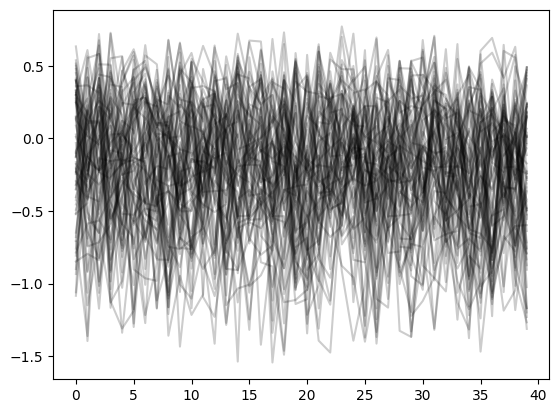

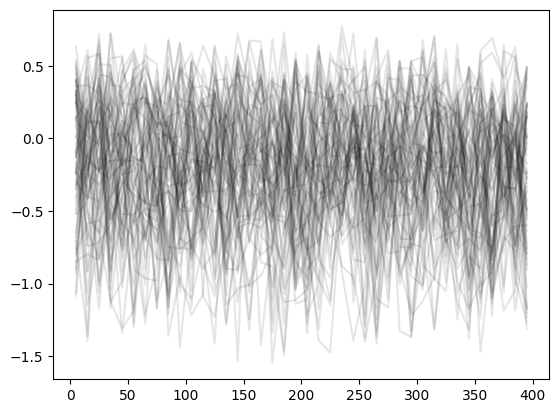

In [1]:
from matplotlib.pyplot import *
from tvb.contrib.rateML.run.regular_run import regularRun

simtime = 400
g = 2
s = 2
dt = 0.1
period = 10
your_gen_model = 'KuramotoT'
(time, data) = regularRun(simtime, g, s, dt, period).simulate_python(your_gen_model)

figure()
plot(time, data[:, 0, :, 0], 'k', alpha=0.1)
show()